# Full-Sized Model Training (Memory-Optimized)

This notebook trains both Backpack and Transformer baseline models on Europarl English-French data with 16 senses.

**Models:**
- Backpack: ~1.02B parameters (16 senses, 4 layers, 4 heads, 256 embd)
- Transformer: ~64M parameters (same architecture, no senses)

**Configuration:**
- Uses parameters from `train_backpack_clean` but with 16 senses
- Memory-optimized: smaller batch size (8), no compilation, smaller context (128)
- Should fit on most GPUs without OOM errors

**Training:**
- 50,000 iterations max
- Automatic checkpoint saving (best val loss + periodic every 500 iterations)
- Resume capability if interrupted


## 1. Setup


In [34]:
# Clone and setup
!git clone https://github.com/kavyavenk/multilingual-backpacks.git
%cd multilingual-backpacks


Cloning into 'multilingual-backpacks'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 489 (delta 10), reused 0 (delta 0), pack-reused 470 (from 1)
Receiving objects: 100% (489/489), 1.69 MiB | 39.22 MiB/s, done.
Resolving deltas: 100% (275/275), done.
/content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks


In [35]:
# Check GPU
!nvidia-smi


Mon Dec  8 06:14:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
# Mount Drive for checkpoints (optional)
from google.colab import drive
import os

try:
    drive.mount('/content/drive')
    drive_checkpoint_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints'
    os.makedirs(drive_checkpoint_dir, exist_ok=True)
    USE_DRIVE = True
    print("✓ Drive mounted - checkpoints will be saved")
except Exception as e:
    USE_DRIVE = False
    print("⚠️  Drive not mounted - checkpoints will only be local")
    print("   (You can download results at the end)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Drive mounted - checkpoints will be saved


In [37]:
# Install dependencies
!pip install -q transformers datasets scipy tqdm matplotlib


In [38]:
# Verify GPU
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


PyTorch: 2.9.0+cu126
CUDA: True
GPU: NVIDIA L4
Memory: 23.80 GB


## 2. Prepare Data


In [39]:
# Prepare Europarl dataset (full dataset - remove max_samples limit for full training)
!python data/europarl/prepare.py --language_pair en-fr


Loading Europarl dataset for en-fr...
Loaded Europarl en-fr from HuggingFace
Using subset of 50000 sentences (out of 2051014 total)
Loading tokenizer: xlm-roberta-base
Processing sentences: 100% 50000/50000 [00:01<00:00, 39796.24it/s]
Total combined texts: 100000
Tokenizing texts (this may take a few minutes)...
Tokenizing 90000 training texts...
Train batches: 100% 90/90 [00:06<00:00, 13.15it/s]
Tokenizing 10000 validation texts...
Val batches: 100% 10/10 [00:00<00:00, 15.18it/s]
Saved train data to /content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/data/europarl/train.bin
Saved val data to /content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/data/europarl/val.bin
Saved metadata to /content/multilingual-backpacks/multilingual-backpacks/multilingual-backpacks/data/europarl/meta.pkl

Vocabulary size: 250002
Data preparation complete!


In [40]:
# Verify data
import os
import pickle

with open('data/europarl/meta.pkl', 'rb') as f:
    meta = pickle.load(f)

print(f"Vocab size: {meta['vocab_size']:,}")
print(f"Languages: {meta['languages']}")

for fname in ['train.bin', 'val.bin']:
    fpath = f"data/europarl/{fname}"
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1e6
        print(f"✓ {fname}: {size:.2f} MB")


Vocab size: 250,002
Languages: ['en', 'fr']
✓ train.bin: 29.29 MB
✓ val.bin: 3.19 MB


## 3. Restore Previous Checkpoints (if any)


In [41]:
# Restore previous checkpoints if exist
import shutil
import json

for model_type in ['backpack', 'transformer']:
    if USE_DRIVE:
        drive_dir = f'/content/drive/MyDrive/{model_type}_full'
        local_dir = f'out/{model_type}_full'

        if os.path.exists(drive_dir):
            shutil.copytree(drive_dir, local_dir, dirs_exist_ok=True)
            print(f"✓ Restored {model_type} checkpoint from Drive")

            if os.path.exists(f"{local_dir}/training_log.json"):
                with open(f"{local_dir}/training_log.json") as f:
                    log = json.load(f)
                print(f"  Completed {len(log['iterations'])} iterations")
                if log['iterations']:
                    print(f"  Last train loss: {log['train_loss'][-1]:.4f}")
                    print(f"  Last val loss: {log['val_loss'][-1]:.4f}")
        else:
            print(f"No previous {model_type} checkpoint found - starting fresh")
    else:
        print(f"Drive not available - {model_type} will start fresh")


✓ Restored backpack checkpoint from Drive
  Completed 501 iterations
  Last train loss: 2.7677
  Last val loss: 3.1621
✓ Restored transformer checkpoint from Drive
  Completed 501 iterations
  Last train loss: 2.6070
  Last val loss: 2.9621


In [45]:
import torch
import configurator  # must import the module so the class exists

ckpt_path = "out/backpack_full/ckpt.pt"

with torch.serialization.safe_globals([configurator.ModelConfig]):
    ckpt = torch.load(ckpt_path, map_location="cpu")

print(ckpt.keys())
print("Iter num:", ckpt.get("iter_num"))
print("Best val loss:", ckpt.get("best_val_loss"))


dict_keys(['model', 'optimizer', 'config', 'iter_num', 'best_val_loss', 'training_log'])
Iter num: 50000
Best val loss: tensor(2.9495)


## 4. Train Backpack Model


In [50]:
# Determine if we should resume or start fresh
import os
backpack_ckpt = 'out/backpack_full/ckpt.pt'
init_from = 'resume' if os.path.exists(backpack_ckpt) else 'scratch'
print(f"Backpack: {init_from}")

# Train Backpack model (using memory-optimized config with 16 senses)
!python train.py \
    --model_type backpack \
    --config train_europarl_scratch_16senses \
    --out_dir out/backpack_full \
    --data_dir europarl \
    --init_from {init_from} \
    --device cuda \
    --dtype float16


Backpack: resume
Loading data...
Loading train.bin
Loading val.bin
Loading meta.pkl
Initializing model...
About to load ckpt
Loading ckpt
Number of parameters: 132.37M
Resumed from checkpoint at iteration 73500
num decayed parameter tensors: 23, with 132,363,264 parameters
num non-decayed parameter tensors: 13, with 6,928 parameters
Starting training...
Resumed: iter_num=73500, best_val_loss=2.8049
Loaded training log from checkpoint with 737 entries
token id bounds:  0 240057
token id bounds:  0 218481
token id bounds:  0 218552
token id bounds:  0 186809
token id bounds:  0 195812
token id bounds:  0 240057
token id bounds:  0 225673
token id bounds:  0 202681
token id bounds:  0 180210
token id bounds:  0 240776
token id bounds:  0 233592
token id bounds:  0 230991
token id bounds:  0 229815
token id bounds:  0 237854
token id bounds:  0 242564
token id bounds:  0 222535
token id bounds:  0 212678
token id bounds:  0 228038
token id bounds:  0 214009
token id bounds:  0 233041
token

In [48]:
# Final backup for Backpack (if Drive available)
if USE_DRIVE:
    drive_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints_real/backpack_full'
    shutil.copytree('out/backpack_full', drive_dir, dirs_exist_ok=True)
    print("✓ Backpack checkpoint saved to Drive")
else:
    print("✓ Backpack training complete - checkpoint saved locally")


✓ Backpack checkpoint saved to Drive


In [49]:
import os
os.listdir('out/backpack_full')

['ckpt.pt', 'training_log.json']

## 5. Train Transformer Baseline


In [ ]:
# Determine if we should resume or start fresh
transformer_ckpt = 'out/transformer_full/ckpt.pt'
init_from = 'resume' if os.path.exists(transformer_ckpt) else 'scratch'
print(f"Transformer: {init_from}")

# Train Transformer baseline model (matching backpack config)
!python train.py \
    --model_type transformer \
    --config train_europarl_transformer_baseline_16senses \
    --out_dir out/transformer_full \
    --data_dir europarl \
    --init_from {init_from} \
    --device cuda \
    --dtype float16


Streaming output truncated to the last 5000 lines.
Y bounds:  0 242661
X bounds:  0 242799
Y bounds:  0 242799
X bounds:  0 241439
Y bounds:  0 241439
X bounds:  0 242799
Y bounds:  0 242799
X bounds:  0 223606
Y bounds:  0 223606
X bounds:  0 242333
Y bounds:  0 242333
X bounds:  0 242328
Y bounds:  0 236674
X bounds:  0 227463
Y bounds:  0 227463
X bounds:  0 234146
Y bounds:  0 234146
X bounds:  0 240625
Y bounds:  0 240625
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 237360
Y bounds:  0 237360
X bounds:  0 230804
Y bounds:  0 230804
X bounds:  0 242627
Y bounds:  0 242627
X bounds:  0 241860
Y bounds:  0 241860
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 238536
Y bounds:  0 238536
X bounds:  0 238536
Y bounds:  0 238536
X bounds:  0 240056
Y bounds:  0 240056
X bounds:  0 191195
Y bounds:  0 191195
X bounds:  0 242799
Y bounds:  0 242799
X bounds:  0 241846
Y bounds:  0 241846
X bounds:  0 238236
Y bounds:  0 238236
X bounds:  0 242987
Y bounds:  0 242987
X bounds:

In [ ]:
# Final backup for Transformer (if Drive available)
if USE_DRIVE:
    drive_dir = '/content/drive/MyDrive/multilingual-backpacks-checkpoints/transformer_full'
    shutil.copytree('out/transformer_full', drive_dir, dirs_exist_ok=True)
    print("✓ Transformer checkpoint saved to Drive")
else:
    print("✓ Transformer training complete - checkpoint saved locally")


✓ Transformer checkpoint saved to Drive


## 6. Visualize Training Results



Backpack Summary:
  Iterations: 501
  Final train loss: 2.7677
  Final val loss: 3.1621
  Loss reduction: 9.7152

Transformer Summary:
  Iterations: 501
  Final train loss: 2.6070
  Final val loss: 2.9621
  Loss reduction: 9.8674


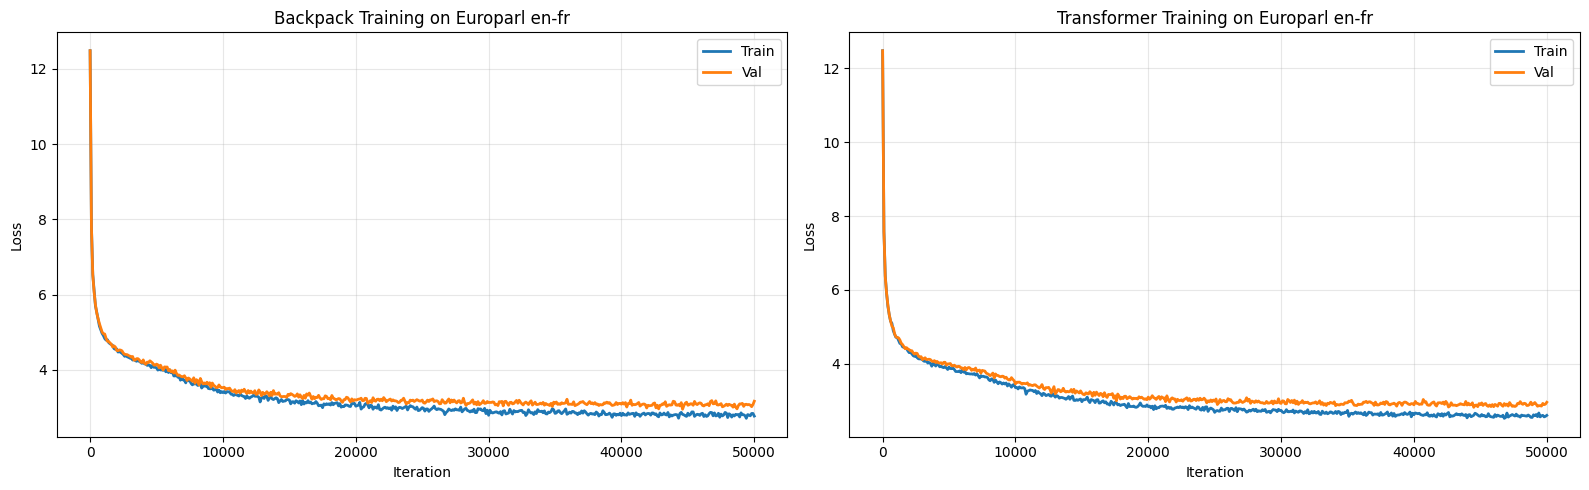

In [ ]:
# Plot loss curves for both models
import json
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, (model_type, model_name) in enumerate([('backpack', 'Backpack'), ('transformer', 'Transformer')]):
    log_path = f'out/{model_type}_full/training_log.json'
    if os.path.exists(log_path):
        with open(log_path) as f:
            log = json.load(f)

        ax = axes[idx]
        ax.plot(log['iterations'], log['train_loss'], label='Train', linewidth=2)
        ax.plot(log['iterations'], log['val_loss'], label='Val', linewidth=2)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.set_title(f'{model_name} Training on Europarl en-fr')
        ax.legend()
        ax.grid(alpha=0.3)

        print(f"\n{model_name} Summary:")
        print(f"  Iterations: {len(log['iterations'])}")
        if log['iterations']:
            print(f"  Final train loss: {log['train_loss'][-1]:.4f}")
            print(f"  Final val loss: {log['val_loss'][-1]:.4f}")
            print(f"  Loss reduction: {log['train_loss'][0] - log['train_loss'][-1]:.4f}")
    else:
        axes[idx].text(0.5, 0.5, f'No training log found\nfor {model_name}',
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{model_name} Training')

plt.tight_layout()
plt.savefig('out/training_comparison.png', dpi=150)
plt.show()


In [ ]:
# Display model information
import torch
from configurator import get_config

for model_type, model_name in [('backpack', 'Backpack'), ('transformer', 'Transformer')]:
    ckpt_path = f'out/{model_type}_full/ckpt.pt'
    if os.path.exists(ckpt_path):
        # Fix: Add weights_only=False to allow loading custom classes from the checkpoint
        checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
        config = checkpoint['config']

        print(f"\n{'='*60}")
        print(f"{model_name.upper()} MODEL")
        print(f"{'='*60}")
        print(f"Embedding dim: {config.n_embd}")
        if model_type == 'backpack':
            print(f"Sense vectors: {config.n_senses}")
        print(f"Layers: {config.n_layer}")
        print(f"Heads: {config.n_head}")
        print(f"Vocab: {config.vocab_size:,}")
        print(f"Block size: {config.block_size}")
        print(f"\nTraining:")
        print(f"  Iterations: {checkpoint.get('iter_num', 0):,}")
        print(f"  Best val loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")

        # Calculate model size
        model_state = checkpoint['model']
        total_params = sum(p.numel() for p in model_state.values())
        model_size_mb = total_params * 2 / 1e6  # float16 = 2 bytes

        print(f"\nTotal params: {total_params:,}")
        print(f"Size: {model_size_mb:.1f} MB (float16)")
        print(f"{'='*60}")



BACKPACK MODEL
Embedding dim: 256
Sense vectors: 16
Layers: 4
Heads: 4
Vocab: 250,002
Block size: 128

Training:
  Iterations: 50,000
  Best val loss: 2.9495

Total params: 132,370,192
Size: 264.7 MB (float16)

TRANSFORMER MODEL
Embedding dim: 256
Layers: 4
Heads: 4
Vocab: 250,002
Block size: 128

Training:
  Iterations: 50,000
  Best val loss: 2.8254

Total params: 131,181,824
Size: 262.4 MB (float16)


## 8. Download Results


In [ ]:
# Package all results
import tarfile

with tarfile.open('full_models_results.tar.gz', 'w:gz') as tar:
    for model_type in ['backpack_full', 'transformer_full']:
        model_dir = f'out/{model_type}'
        if os.path.exists(model_dir):
            tar.add(model_dir, arcname=model_type)
            print(f"✓ Added {model_type}")

# Download
from google.colab import files
files.download('full_models_results.tar.gz')

print("\n✓ Results downloaded")
print("\nContents:")
print("  - backpack_full/ckpt.pt: Backpack model checkpoint")
print("  - backpack_full/training_log.json: Backpack training metrics")
print("  - transformer_full/ckpt.pt: Transformer model checkpoint")
print("  - transformer_full/training_log.json: Transformer training metrics")


✓ Added backpack_full
✓ Added transformer_full


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Results downloaded

Contents:
  - backpack_full/ckpt.pt: Backpack model checkpoint
  - backpack_full/training_log.json: Backpack training metrics
  - transformer_full/ckpt.pt: Transformer model checkpoint
  - transformer_full/training_log.json: Transformer training metrics


In [ ]:
# Fix train.py to load checkpoint with weights_only=False
!sed -i "s/checkpoint = torch.load(ckpt_path, map_location=args.device)/checkpoint = torch.load(ckpt_path, map_location=args.device, weights_only=False)/g" train.py

# Re-run the training command with the correct config
!python train.py \
    --model_type backpack \
    --config train_europarl_scratch_16senses \
    --out_dir out/backpack_full \
    --data_dir europarl \
    --init_from resume \
    --device cuda \
    --dtype float16

Loading data...
Loading train.bin
Loading val.bin
Loading meta.pkl
Initializing model...
About to load ckpt
Loading ckpt
Number of parameters: 132.37M
Resumed from checkpoint at iteration 50000
num decayed parameter tensors: 23, with 132,363,264 parameters
num non-decayed parameter tensors: 13, with 6,928 parameters
Starting training...
Resumed: iter_num=50000, best_val_loss=2.9495
Loaded training log from checkpoint with 501 entries
X bounds:  0 238548
Y bounds:  0 238548
X bounds:  0 223606
Y bounds:  0 223606
X bounds:  0 222428
Y bounds:  0 222428
X bounds:  0 229815
Y bounds:  0 229815
X bounds:  0 238548
Y bounds:  0 238548
X bounds:  0 234694
Y bounds:  0 234694
X bounds:  0 237267
Y bounds:  0 237267
X bounds:  0 234311
Y bounds:  0 234311
X bounds:  0 238536
Y bounds:  0 238536
X bounds:  0 236879
Y bounds:  0 236879
X bounds:  0 233234
Y bounds:  0 233234
X bounds:  0 223606
Y bounds:  0 223606
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 241724
Y bounds:  0 241724
X 